<a href="https://colab.research.google.com/github/CaptainJimbo/MyPortfolio/blob/main/musicGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libaries
import tensorflow as tf
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
import subprocess
import matplotlib.pyplot as plt
from IPython.display import Audio
!apt-get install abcmidi timidity > /dev/null 2>&1
!apt-get install -y abcmidi timidity
!pip install pydub
!pip install IPython

# checking that you are using a GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

# fetching data
print('\nDownloading file...')
!wget -O music.abc "https://dl.dropboxusercontent.com/scl/fi/xyvgohdnz73uy0akyolsb/input.abc?rlkey=lcpg5bp57n46d7129qjprgnuy"


Reading package lists... Done
Building dependency tree       
Reading state information... Done
abcmidi is already the newest version (20200122-1).
timidity is already the newest version (2.14.0-8build1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.

--2023-07-17 18:03:19--  https://dl.dropboxusercontent.com/scl/fi/xyvgohdnz73uy0akyolsb/input.abc?rlkey=lcpg5bp57n46d7129qjprgnuy
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.65.15, 2620:100:6021:15::a27d:410f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.65.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1751713 (1.7M) [text/plain]
Saving to: ‘music.abc’

music.abc           100%[===================>]   1.67M  --.-KB/s    in 0.03s   

2023-07-17 18:03:20 (61.6 MB/s) - ‘music.abc’ saved [1751713/1751713]



In [2]:
# open function inside a with statement so that the file gets closed after reading
with open('music.abc', 'r') as file:
    data = file.read()
# just to have the songs
songs = data.split('\n\n\n')
print(f'There are {len(songs)} songs in the file')

There are 4097 songs in the file


In [3]:
def play(song):
    # writing the song to a new ABC file
    with open('song.abc', 'w') as file:
        file.write(song)
    # converting ABC to MIDI using subprocess
    subprocess.run(["abc2midi", "song.abc", "-o", "song.midi"])
    # converting MIDI to WAV
    subprocess.run(["timidity", "song.midi", "-Ow", "-o", "song.wav"])
    # load and play the audio file
    audio = Audio("song.wav")
    print(song,'\n')
    return audio

In [4]:
print('Lets play the first song\n')
play(songs[0])

Lets play the first song

X: 1
T: The Enchanted Valley
M: 2/4
L: 1/16
B: "O'Neill's 1"
N: "Very slow" "collected by J. O'Neill"
N:
Z: "Transcribed by Norbert Paap, norbertp@bdu.uva.nl"
Z:
K:Gm
G3-A (Bcd=e) | f4 (g2dB) | ({d}c3-B) G2-E2 | F4 (D2=E^F) |
G3-A (Bcd=e) | f4 d2-f2 | (g2a2 b2).g2 | {b}(a2g2 f2).d2 |
(d2{ed}c2) B2B2 | (A2G2 {AG}F2).D2 | (GABc) (d2{ed}c>A) | G2G2 G2z ||
G | B2c2 (dcAB) | G2G2 G3G | B2d2 (gfdc) | d2g2 (g3ga) |
(bagf) (gd)d>c | (B2AG) F-D.D2 | (GABc) d2d2 | (bgfd) cA.F2 |
G2A2 (B2{cB}AG) | A3-G F2-D2 | (GABc) (d2{ed}c>A) | G2G2 G2z2 || 



In [5]:
# the algorithm doesnt understand characters it understands pure numbers i.e. just math
# so I transform the characters to indices, FIRST I need the vocabulary
vocab = sorted(set(data))
print(f'Vocabulary of the abc file, i.e. chords, notes and others',''.join(vocab))

Vocabulary of the abc file, i.e. chords, notes and others 	
 !"#%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_abcdefghijklmnopqrstuvwxyz{|}~


In [6]:
# dictionary to map characters to idxs
ch_to_idx = {char:idx for idx,char in enumerate(vocab)}
# encode function to transform strings to list of idxs
encode = lambda string: [ch_to_idx[s] for s in string]

# dictionary to map idxs to characters
idx_to_ch = {idx:char for idx,char in enumerate(vocab)}
# decode function to transform a ist of idxs to a string
decode = lambda digits: ''.join(idx_to_ch[d] for d in digits)

In [7]:
# Try it
# encode('Hello There'), decode(encode('Hello There'))

In [8]:
batch_size = 4
block_size = 20
vocab_size = len(vocab)
def get_batch(encoded_songs, batch_size, block_size):

    # string has length of len-1 because it starts from 0th place you need n
    n = len(encoded_songs) - 1

    # randomly choose the starting indices for the examples in the training batch
    rnd_idxs = np.random.choice(n-block_size, batch_size)
    input_batch = [encoded_songs[i:i+block_size] for i in rnd_idxs]
    output_batch = [encoded_songs[i+1:i+block_size+1] for i in rnd_idxs]

    # x_batch, y_batch provide the true inputs and targets for network training
    x_batch = np.reshape(input_batch, [batch_size, block_size])
    y_batch = np.reshape(output_batch, [batch_size, block_size])

    return x_batch, y_batch

In [9]:
# Try it
#get_batch(encode(data),batch_size=4, block_size=10)

In [10]:
def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):

  model = tf.keras.Sequential([
    # Layer 1: Embedding layer tranforms each encoded character to an n-dimensional vector
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: Long Short Temr Memory Layer with `rnn_units` for number of units
    #LSTM(rnn_units)

    tf.keras.layers.LSTM(rnn_units, return_sequences=True, recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',stateful=True),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output into the vocabulary size
    tf.keras.layers.Dense(vocab_size)
  ])

  return model

In [11]:
batch_size = 32
block_size = 400
vocab_size = len(vocab)
model = build_model(vocab_size, embedding_dim=256, rnn_units=1024, batch_size=batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           24320     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 95)            97375     
                                                                 
Total params: 5,368,671
Trainable params: 5,368,671
Non-trainable params: 0
_________________________________________________________________


In [12]:
encoded_songs = encode(data)
x, y = get_batch(encoded_songs, batch_size, block_size)
pred = model(x)
print("Input shape:      ", x.shape, "    # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 400)     # (batch_size, sequence_length)
Prediction shape:  (32, 400, 95) # (batch_size, sequence_length, vocab_size)


In [13]:
input_test = decode(x[0])
output_test = decode(tf.random.categorical(pred[0],num_samples=1).numpy().reshape(-1))
print('-'*128)
print('input test\n', input_test)
print('='*128)
print('output test\n', output_test)
print('-'*128)
# WHich SUCKS, because it is untrained of course!

--------------------------------------------------------------------------------------------------------------------------------
input test
 , rjs@gsp.org"
K:A
   (AG) | EAAG  ABcd  | efec d2(cd) | edcB ABcA | BGEF G2(ED) |
          EAAG  ABcd  | efec d2(cd) | eaab aged | c2A2 A2    :|
|: (ef) | gfga g2(ef) | gfec d2(cd) | edcB ABcA | BGEF G2(ED) |
          EAAG  ABcd  | efec d2(cd) | eaab aged | c2A2 A2    :|


X:1748
T:THE REDHAIRED BOY
M:2/4
L:1/16
B:O'NEILL'S 1748
N:"collected by F. O'Neill
Z:Transcribed by A. LEE WORMAN
K:A
(AG)
output test
 iWe3~AkE#q2: K=v/Cl#I ZyYsa[!iQ-C#1&gk@@>hTgk3f kIWNM_L8p.!@&,}v9R5Nf!#T"n[^tE8 /Nlg4oV.j;P?>v2IS8;}B! F~@v","RVpz|D9>zJM|QJi7
\*0/=np2Jy&+jucJuCv]{<F}u;AM;;!
5p
B=sH^aW.,O9|a]UN18]|?*HOF,@R9PO[kl}TdCLy
\r2eAU/Qg)
C6NcE|CR['7Pd!4:?+07[q~Gu'" *7	H
Vl#[Q8Q+H;<wcbRJcbHOw[{WDs%r!\	+	)#"J>G?vrklzy.Qki:~j~ni&"<;0|JJ|u)z8DkR\U-y"zMIy6v?w<ouIJ[C7P(T/Rup"RaynMu+K\IP EBJ9.@ 1y,UR*eHz4.A?[vz8>0{|pa'%Nr,5<2wb
--------------------------------------------

In [14]:
def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss

example_batch_loss = compute_loss(y, pred)
print("loss:", example_batch_loss.numpy().mean())

loss: 4.5548015


In [15]:
num_training_iterations = 1000
batch_size = 32
block_size = 200
vocab_size = len(vocab)
learning_rate = 1e-1  # 1e-5 and 1e-1
embedding_dim = 256
rnn_units = 1024

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

# new model using hyperparameters above
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
optimizer = tf.keras.optimizers.Adam()
model.summary()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = compute_loss(y, y_hat)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

import matplotlib.pyplot as plt
def plot_training():
    plt.plot(np.arange(1,num_training_iterations+1),history)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.xlim(1, num_training_iterations)
    plt.show()

def plot_loss_step(x,y):
    plt.plot(x, y, color='b')  # Plot points up to current one
    plt.xlim(0, num_training_iterations)  # Fix the x limits to your range
    plt.ylim(0, 5)  # Fix the y limits to sine range
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()  # Show the plot
    #plt.pause(0.01)  # Pause for a moment
    clear_output(wait=True)  # Clear output

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (32, None, 256)           24320     
                                                                 
 lstm_1 (LSTM)               (32, None, 1024)          5246976   
                                                                 
 dense_1 (Dense)             (32, None, 95)            97375     
                                                                 
Total params: 5,368,671
Trainable params: 5,368,671
Non-trainable params: 0
_________________________________________________________________


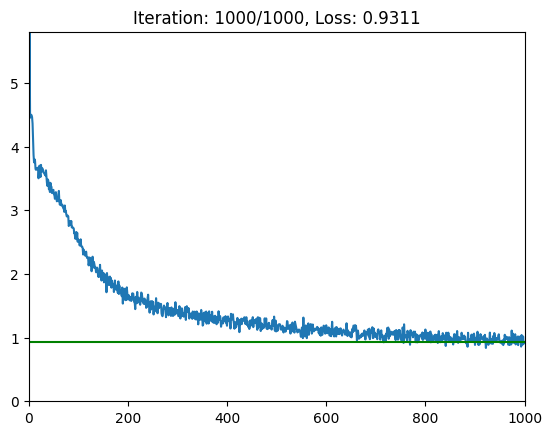

In [16]:
##################
# Begin training!#
##################
from IPython.display import clear_output
history = []
#plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
#if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in range(1,num_training_iterations+1):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(encode(data), batch_size, block_size)
  loss = train_step(x_batch, y_batch)
  # Update the progress bar
  history.append(loss.numpy().mean())
  plt.xlim(0,num_training_iterations)
  plt.ylim(0,max(history))
  plt.plot(np.arange(0,iter),history)
  plt.axhline(loss.numpy().mean(),color='green')
  plt.title('Iteration: {}/{}, Loss: {:.4f}'.format(iter,num_training_iterations, loss.numpy().mean()))
  plt.show()
  clear_output(wait=True)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [17]:
stop

NameError: ignored

##################
# Begin training!#
##################

history = []
#plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

    # Grab a batch and propagate it through the network
    x_batch, y_batch = get_batch(encode(data), batch_size, block_size)
    loss = train_step(x_batch, y_batch)
    # Update the progress bar
    history.append(loss.numpy().mean())
    #plot_loss_step(iter+1,history[-1])
    
    # Update the model with the changed weights!
    if iter % 100 == 0:
        model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output

X = np.linspace(0, 2*math.pi, 100)
Y = np.sin(X)

def plot_loss(x,y):
    plt.plot(x, y, color='b')  # Plot points up to current one
    plt.xlim(0, 2*math.pi)  # Fix the x limits to your range
    plt.ylim(0, 1)  # Fix the y limits to sine range
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend('Hello There')
    plt.show()  # Show the plot
    #plt.pause(0.01)  # Pause for a moment
    clear_output(wait=True)  # Clear output

for i in range(len(X)):
  plot_loss(X[:i+1], Y[:i+1])

#for i in range(len(X)):

#    plt.plot(X[:i+1], Y[:i+1], color='b')  # Plot points up to current one
#    plt.xlim(0, 2*math.pi)  # Fix the x limits to your range
##    plt.ylim(-1, 1)  # Fix the y limits to sine range
##    plt.show()  # Show the plot
#    #plt.pause(0.01)  # Pause for a moment
#    clear_output(wait=True)  # Clear output


